In [17]:
import torch
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import os.path as osp
import networkx as nx
import time
path='~/../../tigress/mcranmer/merger_trees/isotrees/'
transform_path='~/../../tigress/cj1223/gmdata/transformer'

In [18]:
cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
is_cat=np.array([bool(i) for i in is_cat])
i0,i1=0,0
j0,j1=0,0
k0,k1=0,0

In [19]:
cols=cols[~is_cat[cols]]

In [20]:
allsplit=[]
for i in range(i0,i1+1):
    for j in range(j0,j1+1):
        for k in range(k0,k1+1):
            print(f'Loading isotree {i}_{j}_{k}')
            start=time.time()
            pd1=pd.read_table(path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+') # consider enforcing dtypes upon import
            raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
            trees=raw[raw.isna()['A[z]']] 
            halos=raw[~raw.isna()['A[z]']] 
            f,it="float64", "int64"
            cs=[f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f,f]
            dicts = {}
            keys = halos.columns[1:26]
            castto = cs
            for d, key in enumerate(keys):
                    dicts[key] = castto[d]
            halos=halos.astype(dicts)
            print(f'isotree {i}_{j}_{k} loaded, splitting to tree')
            spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
            splits=[]
            for s in tqdm(spli):
                if np.log10(s[0,10])>10:
                    splits.append(s)
            splits=np.array(splits, dtype=object)
            print('Mass split done')
            split=[]
            for tree in tqdm(splits):
                s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                split.append(s[:,cols])
            split=np.array(split, dtype=object)
            allsplit.append(split)
            
            stop=time.time()
            print(f'Done with tree. \n Time elapsed {stop-start} s')
            

Loading isotree 0_0_0


/home/cj1223/.conda/envs/juptorch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


isotree 0_0_0 loaded, splitting to tree


100%|█████████████████████████████████████████████████████| 48505/48505 [00:00<00:00, 391817.01it/s]


Mass split done


100%|███████████████████████████████████████████████████████████| 770/770 [00:00<00:00, 3312.38it/s]

Done with tree. 
 Time elapsed 61.70936632156372 s


In [21]:
fin=[]
for i in range(len(allsplit)):
    fin.append(np.vstack(allsplit[i]))
a=np.vstack(fin)

In [22]:
hard=[0,2,15]
def logit(x):
    return np.log10((x+0.001)/(1.01-x))
##logit transform the hards
for h in hard:
    i=np.where(cols==h)
    a[:,i]=logit(a[:,i])
log=[10,38, 39, 40, 41, 42]

def logt(x):
    return np.log10(x+1)
for l in log:
    i=np.where(cols==l)
    a[:,i]=logt(a[:,i])
# log transform masses


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


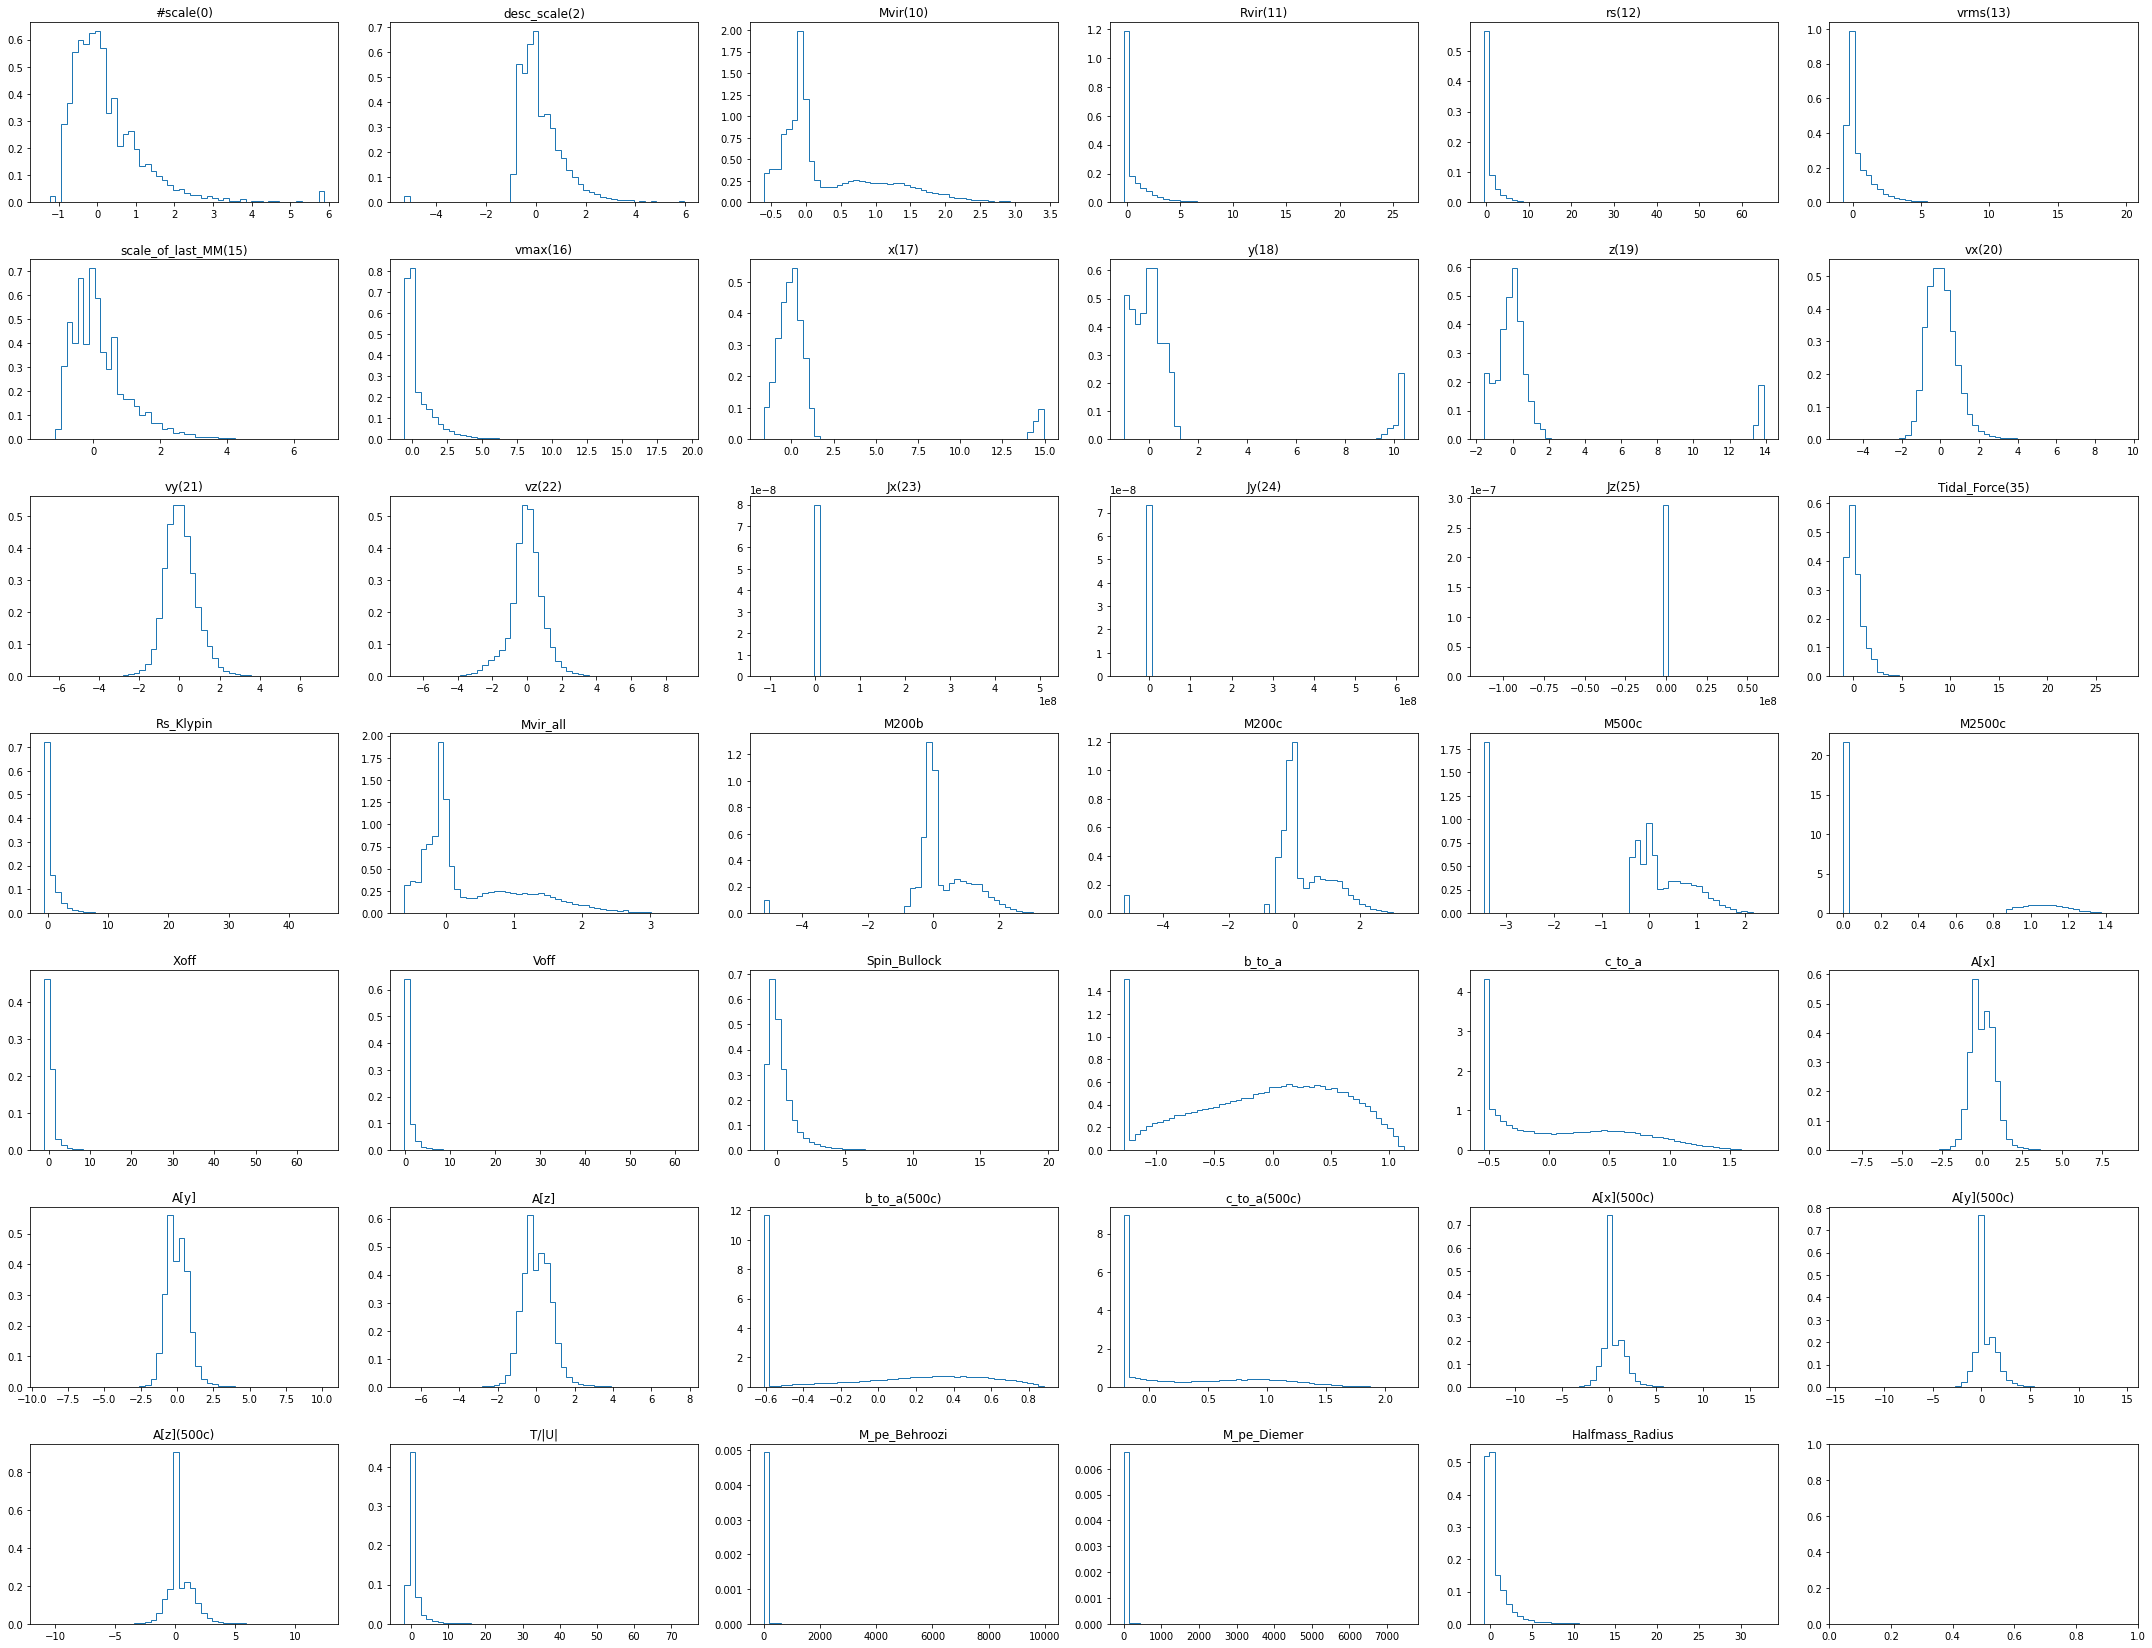

In [36]:
from sklearn.preprocessing import RobustScaler

fig,ax=plt.subplots(nrows=7,ncols=6, figsize=(30,23))
ax=ax.flatten()
robust={}
for i in range(len(cols)):
    print(i)
    t=RobustScaler().fit(a[:,i].reshape(-1,1))
    new=t.transform(a[:,i].reshape(-1,1))
    robust[cols[i]]=t
    ax[i].hist(new, bins=50, density=1, histtype='step');
    ax[i].set(title=halos.columns[cols+1][i])
# plt.hist(a[:,n], bins=100, density=1);
fig.tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


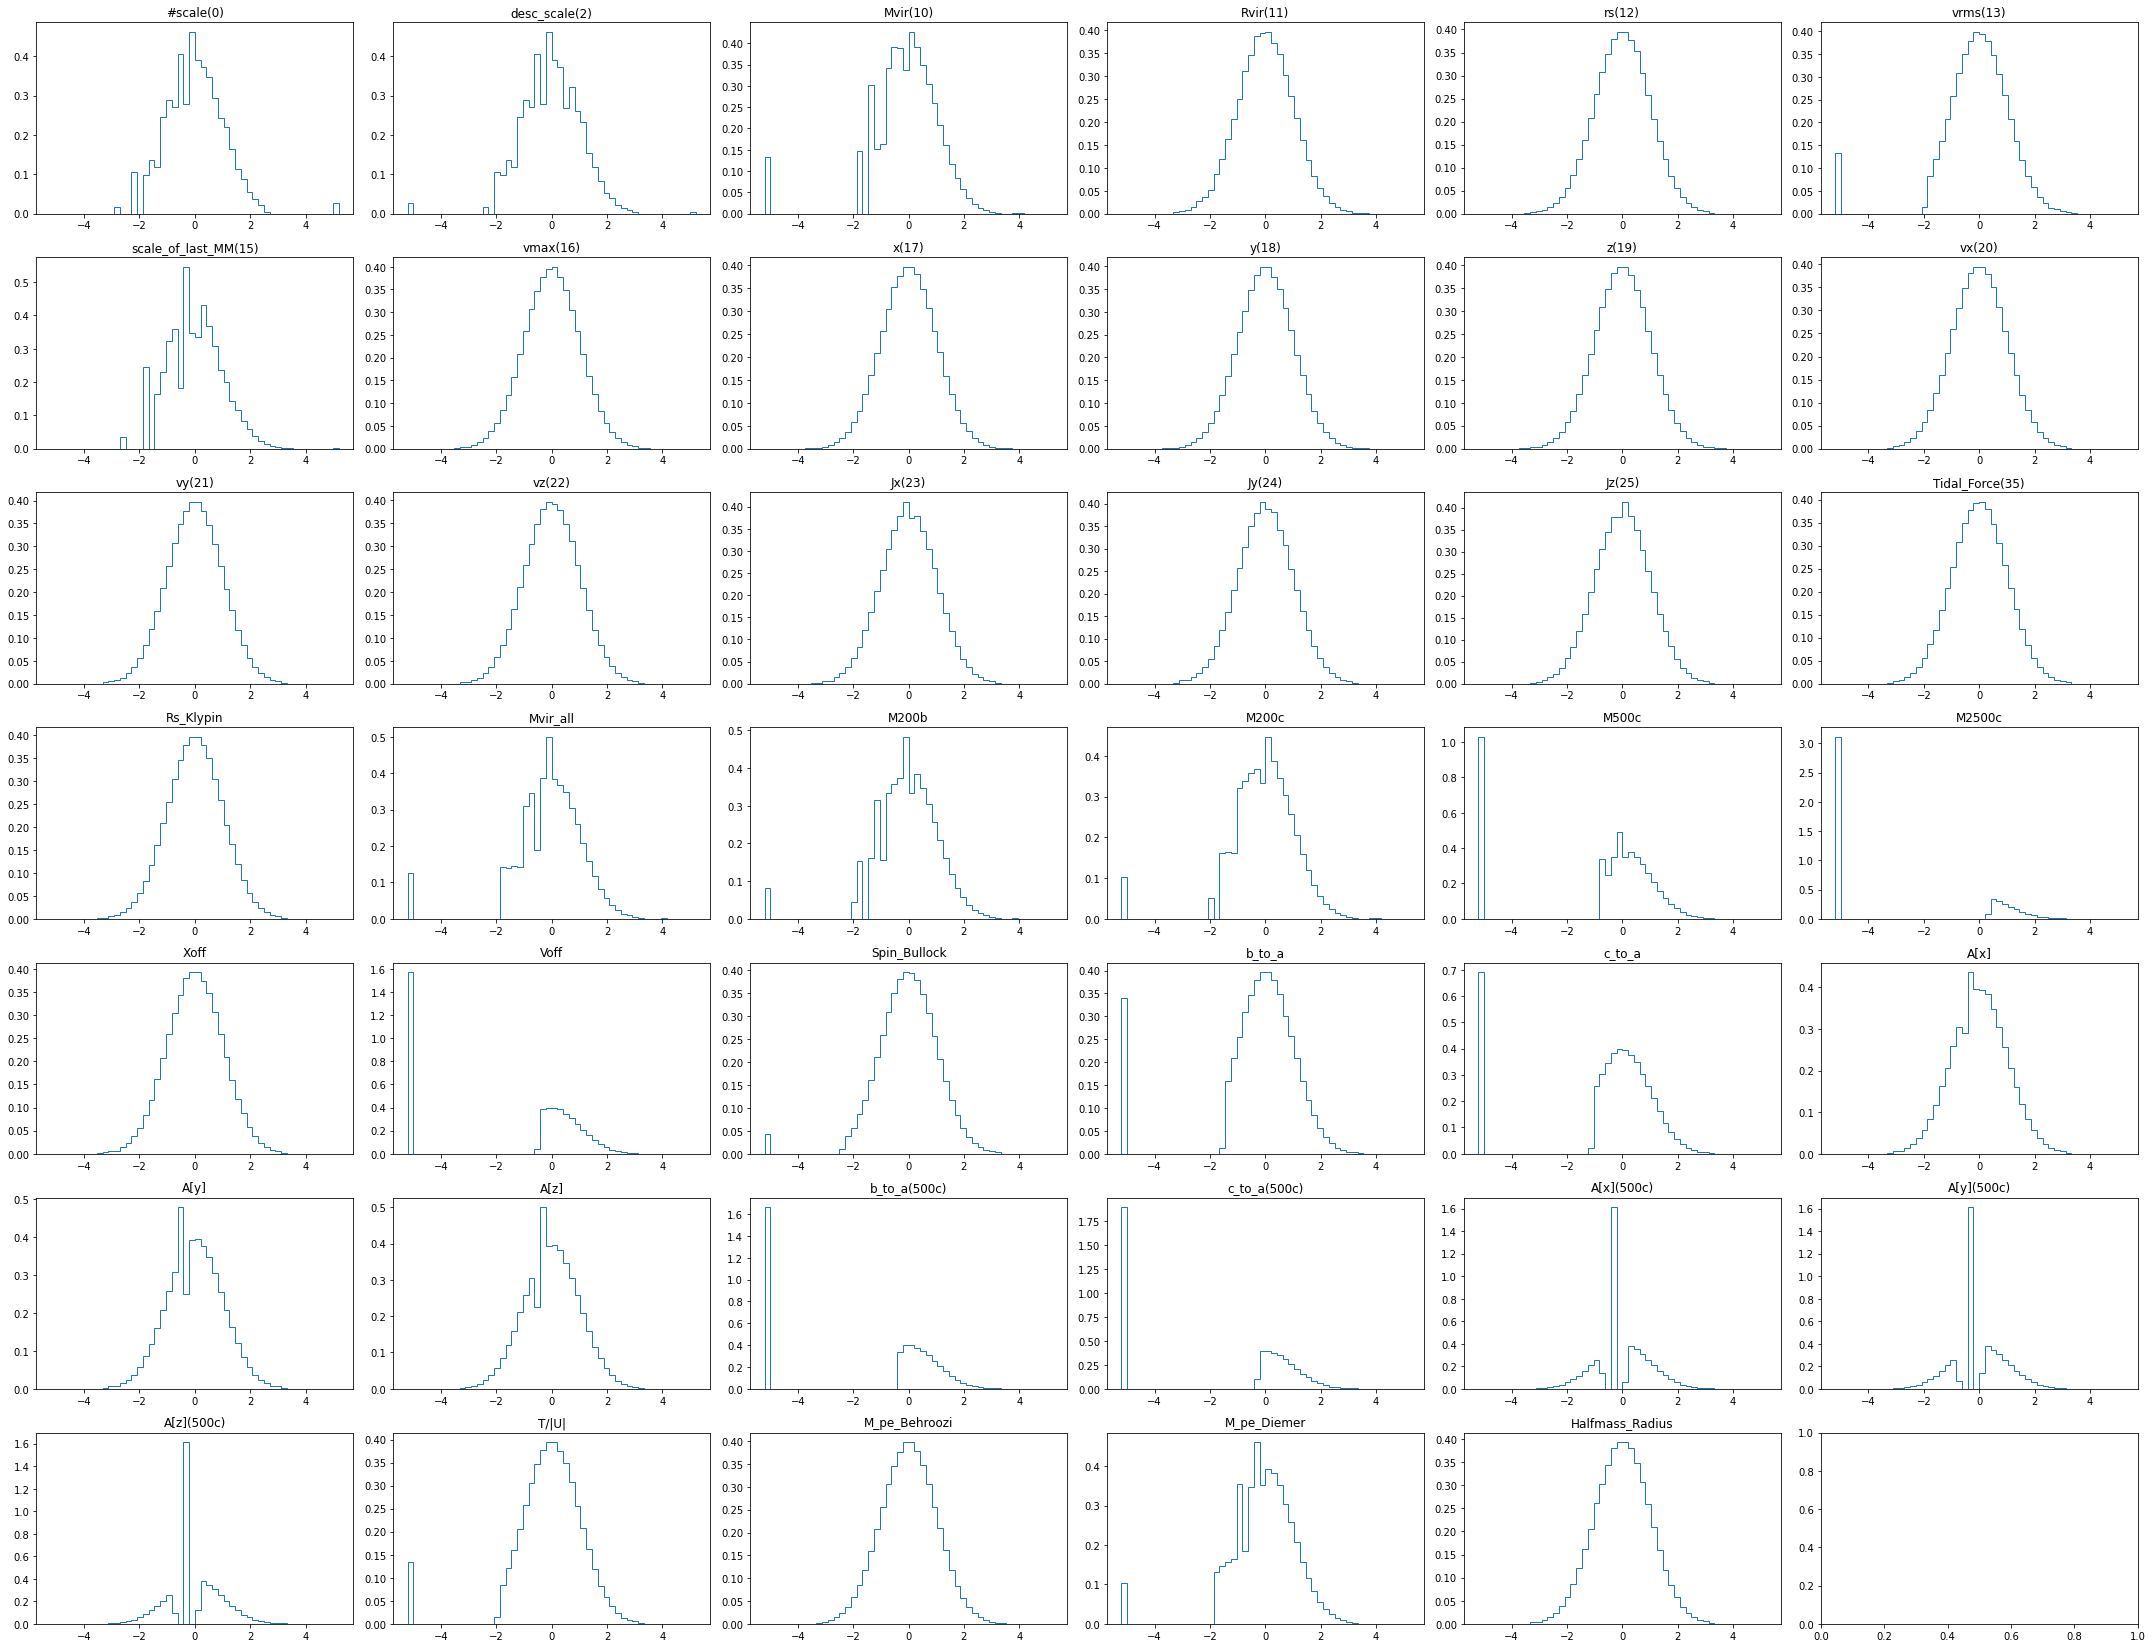

In [38]:
from sklearn.preprocessing import QuantileTransformer

fig,ax=plt.subplots(nrows=7,ncols=6, figsize=(30,23))
ax=ax.flatten()
quantile={}
for i in range(len(cols)):
    print(i)
    t=QuantileTransformer(output_distribution='normal').fit(a[:,i].reshape(-1,1))
    new=t.transform(a[:,i].reshape(-1,1))
    quantile[cols[i]]=t
    ax[i].hist(new, bins=50, density=1, histtype='step');
    ax[i].set(title=halos.columns[cols+1][i])

fig.tight_layout()

In [39]:
with open(f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/quantile_allfeat.pkl', 'wb') as handle:
    pickle.dump(quantile, handle)

In [40]:
with open(f'../../../../scratch/gpfs/cj1223/GraphStorage/transformers/robust_allfeat.pkl', 'wb') as handle:
    pickle.dump(robust, handle)

In [50]:
halos[halos.columns[cols+1]]=t.transform(halos[halos.columns[cols+1]])

In [54]:
halos[halos.columns[cols+1]].describe()

,#scale(0),desc_scale(2),Mvir(10),Rvir(11),rs(12),vrms(13),scale_of_last_MM(15),vmax(16),x(17),y(18),...,A[z],b_to_a(500c),c_to_a(500c),A[x](500c),A[y](500c),A[z](500c),T/|U|,M_pe_Behroozi,M_pe_Diemer,Halfmass_Radius
count,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,...,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06,4.835849e+06
mean,1.883431e+00,1.970100e+00,5.199338e+00,1.280390e-01,-8.140369e-01,-5.480265e-01,2.147283e+00,-4.555392e-01,1.165554e-01,3.692710e-02,...,-1.204431e-01,1.870108e-03,-2.142522e-01,1.320370e-02,-1.461655e-02,-2.123878e-03,-7.280826e-01,2.278567e-01,-3.046606e-02,-6.259096e-01
std,2.258510e-01,2.756898e-01,3.286260e-14,4.709184e-01,9.148286e-01,6.976119e-01,2.254315e-01,7.258315e-01,1.128422e+00,9.716761e-01,...,6.698532e-01,1.894484e+00,2.150690e+00,8.320127e-01,8.299637e-01,8.372129e-01,8.404979e-01,4.443714e-01,5.977227e-01,8.728244e-01
min,1.392604e+00,1.323862e+00,5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,1.827374e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,...,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00,-5.199338e+00
25%,1.703797e+00,1.748307e+00,5.199338e+00,-1.466757e-02,-1.507978e+00,-1.063355e+00,1.978017e+00,-9.594396e-01,-6.925783e-01,-6.224482e-01,...,-6.315203e-01,-1.616932e-01,-9.521702e-02,-8.342357e-01,-8.723197e-01,-8.616395e-01,-1.354020e+00,1.324746e-01,-3.005420e-01,-1.284096e+00
50%,1.897144e+00,1.979152e+00,5.199338e+00,2.389890e-01,-8.022257e-01,-6.104835e-01,2.074731e+00,-4.224828e-01,2.253863e-01,4.192900e-02,...,-5.101711e-02,3.760580e-01,3.248064e-01,2.970248e-01,2.715262e-01,2.860415e-01,-8.698463e-01,2.852258e-01,1.321130e-01,-5.447590e-01
75%,2.073580e+00,2.195772e+00,5.199338e+00,3.634201e-01,-9.864339e-02,-3.053258e-02,2.264641e+00,1.093651e-01,9.804261e-01,7.383325e-01,...,3.071347e-01,1.008065e+00,9.238382e-01,6.279160e-01,5.919693e-01,6.113820e-01,-2.136361e-01,4.117455e-01,3.216106e-01,9.747873e-02
max,2.245320e+00,2.438765e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,3.057478e+00,5.199338e+00,5.199338e+00,5.199338e+00,...,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00,5.199338e+00


In [16]:
with open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/transform_all.pkl', 'wb') as handle:
    pickle.dump(t, handle)